# Skin Cancer Detection using Machine Learning and Computer Vision

## Project Description

This project aims to develop a robust and accurate skin cancer detection system using machine learning and computer vision techniques. By leveraging a dataset of skin lesion images, the system will be trained to classify images into different categories of skin cancer, aiding in early diagnosis and treatment. The project involves data preprocessing, feature extraction, model training, and evaluation to ensure high performance and reliability.

In [149]:
# Étape 1 : Installer les bibliothèques nécessaires
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pydot
%pip install pydot graphviz


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetB0 # type: ignore #ingore the warning
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, Flatten, GlobalAveragePooling2D # type: ignore #ingore the warning
from tensorflow.keras.models import Model, Sequential # type: ignore #ingore the warning
from tensorflow.keras.optimizers import Adam # type: ignore #ingore the warning
from tensorflow.keras.utils import plot_model # type: ignore #ingore the warning
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore #ingore the warning
from tensorflow.keras.applications.efficientnet import preprocess_input # type: ignore #ingore the warning


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    plt.subplot(2, 1, subplot)  # S'assurer d'avoir un bon placement dans la grille (2x1)
    plt.gca().set_facecolor('#F8F8F8')  # change the background color
    plt.plot(training)
    plt.plot(validation)
    plt.title('model ' + title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid.'])

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
#If TPU not found try with GPUs
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

[]
[]
Running on CPU
Number of accelerators:  1


In [151]:
# Charger le fichier CSV
metadata = pd.read_csv("./DataBase/Images/metadata.csv")

# Ajouter le chemin complet des images
metadata['image_path'] = metadata['isic_id'].apply(lambda x: f"./DataBase/Images/{x}.jpg")

# Encoder les labels (0 = benign, 1 = malignant)
metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})

metadata = metadata.dropna(subset=['label'])
metadata = metadata[['image_path', 'label', 'age_approx','sex']]
# print(metadata.head())
print(metadata.head())

                            image_path  label  age_approx   sex
0   ./DataBase/Images/ISIC_9481737.jpg    1.0          30  male
1   ./DataBase/Images/ISIC_0848988.jpg    1.0          30  male
59  ./DataBase/Images/ISIC_0024295.jpg    1.0          30  male
60  ./DataBase/Images/ISIC_0024155.jpg    0.0          30  male
61  ./DataBase/Images/ISIC_0024154.jpg    0.0          30  male


In [152]:
# TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
# TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')
BATCH_SIZE = 10 * strategy.num_replicas_in_sync
IMAGE_SIZE = [100, 100]
AUTO = tf.data.experimental.AUTOTUNE
imSize = 100
EPOCHS = 20

# Définir l'entrée du modèle
input_layer = Input(shape=(imSize, imSize, 3))


In [153]:
# Fonction pour charger une image
def load_image_and_label(row):
    image = tf.io.read_file(row['image_path'])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image, [imSize, imSize])  # Redimensionner
    label = row['label']
    return image, label

# Convertir le DataFrame en dataset
def create_tf_dataset(metadata_df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(metadata_df.to_dict('list'))
    dataset = dataset.map(lambda row: load_image_and_label(row), num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

# Créer des ensembles d'entraînement et de validation
training_metadata = metadata.sample(frac=0.8, random_state=42)
validation_metadata = metadata.drop(training_metadata.index)
print(training_dataset, training_metadata)
print("Training set: ", training_metadata.shape[0])

training_dataset = create_tf_dataset(training_metadata, batch_size=BATCH_SIZE)
validation_dataset = create_tf_dataset(validation_metadata, batch_size=BATCH_SIZE)

print("Training dataset: ", len(training_dataset))

num_batches = sum(1 for _ in training_dataset)
print("Number of batches:", num_batches)

# Compter le nombre d'images dans chaque ensemble
nb_training_images = len(training_dataset)
# nb_test_images = count_data_items(TEST_FILENAMES)
nb_validation_images = len(validation_dataset)
validation_steps = nb_validation_images // BATCH_SIZE
STEPS_PER_EPOCH = nb_training_images // BATCH_SIZE 

print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files"
.format(len(metadata), len(training_dataset), len(validation_dataset)))

# print("Train dataset: ", training_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>                             image_path  label  age_approx   sex
65  ./DataBase/Images/ISIC_0012519.jpg    1.0          20  male
1   ./DataBase/Images/ISIC_0848988.jpg    1.0          30  male
62  ./DataBase/Images/ISIC_0024153.jpg    0.0          30  male
0   ./DataBase/Images/ISIC_9481737.jpg    1.0          30  male
64  ./DataBase/Images/ISIC_0021883.jpg    0.0          35  male
59  ./DataBase/Images/ISIC_0024295.jpg    1.0          30  male
66  ./DataBase/Images/ISIC_0012430.jpg    1.0          35  male
61  ./DataBase/Images/ISIC_0024154.jpg    0.0          30  male
Training set:  8
Training dataset:  1
Number of batches: 1
Pattern matches 10 data files. Splitting dataset into 1 training files and 1 validation files


In [154]:
# Charger le modèle EfficientNetB0 préentraîné sans la couche de classification finale
with strategy.scope():
    base_model = tf.keras.Sequential([
        EfficientNetB0(
            input_shape=(imSize, imSize, 3),
            weights='imagenet',
            include_top=False
        )
    ])

# Geler les couches du modèle de base pour conserver les poids préentraînés
base_model.trainable = False




In [155]:
# Passer l'entrée à travers le modèle de base
x = base_model(input_layer, training=False)  # `input_layer` 
x = Flatten()(x)  # Aplatir les caractéristiques extraites


# Ajout de couches fully connected pour la classification
x = Dense(128, activation="relu")(x)  # Couche dense
x = Dropout(0.5)(x)  # Dropout pour régularisation
output = Dense(1, activation="sigmoid")(x)  # Sigmoid pour une classification binaire

# Définir le modèle final avec une seule entrée (image)
model = Model(inputs=input_layer, outputs=output)


In [156]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimiseur Adam
    loss="binary_crossentropy",          # Fonction de perte pour la classification binaire
    metrics=["accuracy"]                 # Suivi de la précision
)

# Résumé du modèle
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,671,268 (25.45 MB)

 Trainable params: 2,621,697 (10.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [157]:
# Visualisation de l'architecture du modèle
# plot_model(model, show_shapes=True, to_file="efficientnetb0_model.png")

In [158]:
def learning_rate_function(epoch):
    LR_START = 0.00001 # Taux d'apprentissage initial
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync # Taux d'apprentissage maximal
    LR_MIN = 0.00001 # Taux d'apprentissage minimal
    LR_RAMPUP_EPOCHS = 5 # nombre d'époques pendant lesquelles le taux d'apprentissage augmente linéairement.
    LR_SUSTAIN_EPOCHS = 0 # nombre d'époques où le taux reste maximal
    LR_EXP_DECAY = .8 # taux de décroissance exponentielle du taux d'apprentissage après les périodes de "ramp-up" et de "soutien"
    

    # Augmentation (pour les premières LR_RAMPUP_EPOCHS époques) : le taux d'apprentissage commence à LR_START et monte linéairement jusqu'à LR_MAX
    if epoch < LR_RAMPUP_EPOCHS: 
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START

    # Soutien (pour les LR_SUSTAIN_EPOCHS suivantes) : le taux d'apprentissage reste constant à LR_MAX
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    # Décroissance (pour les époques restantes) : le taux d'apprentissage diminue exponentiellement
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose=1)

In [159]:
history = model.fit(training_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=validation_dataset,callbacks=[lr_schedule])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2500 - loss: 1.1787 - val_accuracy: 0.5000 - val_loss: 0.7486 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2500 - loss: 1.0279 - val_accuracy: 0.5000 - val_loss: 0.6959 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3750 - loss: 0.7544 - val_accuracy: 0.5000 - val_loss: 0.7349 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.3750 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.8983 - learning_rate: 3.4000e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.

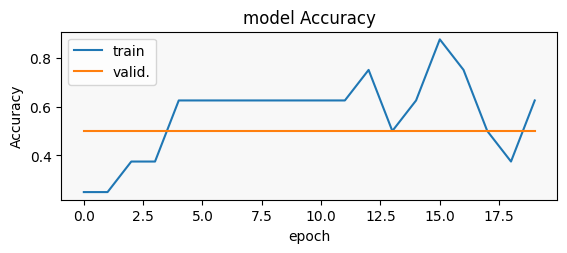

In [192]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 2)


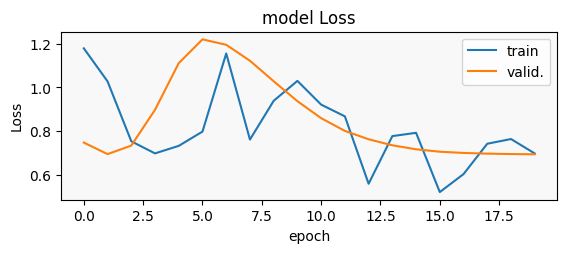

In [193]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 2)

In [194]:
# Fonction pour charger les matrices Y, Cb, Cr à partir du fichier
def load_ycbcr_from_file(file_path):
    """
    Charger les matrices Y, Cb, Cr à partir d'un fichier texte.
    Les fichiers doivent contenir trois sections avec des matrices pour chaque composante.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Identifier les sections et extraire les matrices
    y_start = lines.index("Matrice de luminance (Y):\n") + 1
    cb_start = lines.index("Matrice de chrominance (Cb):\n") + 1
    cr_start = lines.index("Matrice de chrominance (Cr):\n") + 1

    y = np.loadtxt(lines[y_start:cb_start - 1], dtype=np.float32)
    cb = np.loadtxt(lines[cb_start:cr_start - 1], dtype=np.float32)
    cr = np.loadtxt(lines[cr_start:], dtype=np.float32)

    return y, cb, cr

In [195]:
# Fonction pour préparer l'entrée pour le modèle
def prepare_ycbcr_input(y, cb, cr):
    """
    Prépare l'entrée pour le modèle à partir des matrices Y, Cb, Cr.
    """
    # Empiler les canaux Y, Cb, Cr pour former une image (100, 100, 3)
    image = np.stack([y, cb, cr], axis=-1)  # Shape: (100, 100, 3)

    # Normaliser l'image (en utilisant une normalisation simple, pas celle d'ImageNet)
    image = image / 255.0  # Normalisation simple entre 0 et 1

    # Ajouter la dimension du batch (1, 100, 100, 3)
    image = np.expand_dims(image, axis=0)

    return image

In [196]:
# Fonction de prédiction
def predict_skin_cancer(file_path):
    """
    Prédire à partir des matrices Y, Cb, Cr chargées depuis un fichier.
    """
    # Charger les matrices Y, Cb, Cr à partir du fichier
    y, cb, cr = load_ycbcr_from_file(file_path)

    # Préparer l'entrée pour le modèle
    ycbcr_input = prepare_ycbcr_input(y, cb, cr)


    # Prédiction
    prediction = model.predict(ycbcr_input)

    # Interprétation
    if prediction[0] > 0.5:
        return f"Maligne (probabilité {prediction[0][0]:.2f})"
    else:
        return f"Bénigne (probabilité {1 - prediction[0][0]:.2f})"

# Exemple d'utilisation
file_path = "./DataBase/Matrices/ISIC_0001120_matrices.txt"
result = predict_skin_cancer(file_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Maligne (probabilité 0.52)
